In [ ]:
# utils_pde_poisson2d.py
# ---------------------------------------------------------------------
# 2-D Poisson equation on Ω = (0,1) × (0,1)
#   Δu(x,y) + 2π² sin(πx) sin(πy) = 0,
# with homogeneous Dirichlet boundaries u = 0 on ∂Ω.
# The analytic solution is  u*(x,y) = sin(πx)·sin(πy).
# ---------------------------------------------------------------------
from interface_pde import BasePDE

import torch
import math


class Poisson2D(BasePDE):
    """2-D Poisson equation with zero Dirichlet BC on the unit square."""

    def __init__(self,
                 domain=((0.0, 1.0), (0.0, 1.0)),
                 true_solution=lambda xy: torch.sin(math.pi * xy[..., 0:1]) *
                                           torch.sin(math.pi * xy[..., 1:2])):
        """
        domain: ((x0, x1), (y0, y1)) describing Ω.
        true_solution: callable for the exact u(x, y); useful for UQ metrics.
        """
        self.x0, self.x1 = domain[0]
        self.y0, self.y1 = domain[1]
        self.true_solution = true_solution  # keep same attribute name convention

    # ------------------------------------------------------------------
    # Forcing term f(x,y) chosen so that u* = sin(πx) sin(πy) is exact.
    # ------------------------------------------------------------------
    def _forcing(self, xy):
        x = xy[..., 0:1]
        y = xy[..., 1:2]
        return 2 * (math.pi ** 2) * torch.sin(math.pi * x) * torch.sin(math.pi * y)

    # ------------------------------------------------------------------
    # PDE residual ‖ Δu + f ‖² on a set of interior collocation points
    # ------------------------------------------------------------------
    def residual(self, model, coloc_pt_num):
        # Uniform interior sampling
        x = torch.rand(coloc_pt_num, 1) * (self.x1 - self.x0) + self.x0
        y = torch.rand(coloc_pt_num, 1) * (self.y1 - self.y0) + self.y0
        xy = torch.cat([x, y], dim=1).to(dtype=torch.float32)
        return (self._residual(model, xy) ** 2).mean()

    def _residual(self, model, xy):
        xy = xy.requires_grad_(True)
        u = model(xy)                                      # u(x,y)
        grad_u = torch.autograd.grad(
            u, xy, grad_outputs=torch.ones_like(u), create_graph=True
        )[0]                                               # ∇u = (u_x, u_y)

        u_x = grad_u[:, 0:1]
        u_y = grad_u[:, 1:2]

        u_xx = torch.autograd.grad(
            u_x, xy, grad_outputs=torch.ones_like(u_x), create_graph=True
        )[0][:, 0:1]                                       # u_xx
        u_yy = torch.autograd.grad(
            u_y, xy, grad_outputs=torch.ones_like(u_y), create_graph=True
        )[0][:, 1:2]                                       # u_yy

        return u_xx + u_yy + self._forcing(xy)             # Δu + f(x,y)

    # ------------------------------------------------------------------
    # Dirichlet boundary loss (u ≡ 0 on ∂Ω)
    # ------------------------------------------------------------------
    def boundary_loss(self, model, n_b=500):
        # two random sets of points along each pair of opposing edges
        x = torch.rand(n_b, 1) * (self.x1 - self.x0) + self.x0
        y = torch.rand(n_b, 1) * (self.y1 - self.y0) + self.y0

        left   = torch.cat([torch.full_like(y, self.x0), y], dim=1)
        right  = torch.cat([torch.full_like(y, self.x1), y], dim=1)
        bottom = torch.cat([x, torch.full_like(x, self.y0)], dim=1)
        top    = torch.cat([x, torch.full_like(x, self.y1)], dim=1)

        xy_bdry = torch.cat([left, right, bottom, top], dim=0).to(dtype=torch.float32)
        u_pred = model(xy_bdry)
        return (u_pred ** 2).mean()
    
    # ------------------------------------------------------------------
    # Generate synthetic observations in 2-D
    # ------------------------------------------------------------------
    def data_generation(
        self,
        size: int,
        noise: float = 0.0,
        true_solution: callable = None,
        seed: int | None = None,
        device: torch.device | None = None
    ):
        """
        Draw `size` random points (x, y) inside Ω and return
        (X_train, Y_train) with optional Gaussian noise.

        Returns
        -------
        X_train : torch.Tensor  shape [size, 2]   each row = [x , y]
        Y_train : torch.Tensor  shape [size, 1]   u*(x,y) + ε
        """
        if seed is not None:
            torch.manual_seed(seed)

        if device is None:
            device = torch.device("cpu")

        # 1️⃣  Sample (x,y) uniformly from Ω
        xs = (self.x1 - self.x0) * torch.rand(size, 1, device=device) + self.x0
        ys = (self.y1 - self.y0) * torch.rand(size, 1, device=device) + self.y0
        X_train = torch.cat([xs, ys], dim=1).float()          # [size, 2]

        # 2️⃣  Evaluate the noiseless truth
        if true_solution is None:
            if hasattr(self, "true_solution") and callable(self.true_solution):
                true_solution = self.true_solution
            else:
                raise ValueError(
                    "Provide a `true_solution` callable or set `self.true_solution`."
                )
        Y_clean = true_solution(X_train)                      # [size, 1]

        # 3️⃣  Add Gaussian noise if requested
        if noise > 0.0:
            Y_train = Y_clean + noise * torch.randn_like(Y_clean)
        else:
            Y_train = Y_clean.clone()

        return X_train, Y_train

ep     1 | L=1.01e+02 | data=1.45e-01 | pde=9.97e+01  ic=0.00e+00  bc=2.46e-02 | lr=3.00e-03
ep   500 | L=7.37e+00 | data=8.22e-02 | pde=6.34e+00  ic=0.00e+00  bc=1.24e-01 | lr=3.00e-03
ep  1000 | L=5.26e+00 | data=6.66e-02 | pde=4.40e+00  ic=0.00e+00  bc=1.06e-01 | lr=3.00e-03
ep  1500 | L=3.93e+00 | data=7.31e-02 | pde=3.08e+00  ic=0.00e+00  bc=9.76e-02 | lr=3.00e-03
ep  2000 | L=3.73e+00 | data=7.14e-02 | pde=2.87e+00  ic=0.00e+00  bc=1.01e-01 | lr=3.00e-03
ep  2500 | L=3.25e+00 | data=7.53e-02 | pde=2.42e+00  ic=0.00e+00  bc=9.04e-02 | lr=3.00e-03
ep  3000 | L=3.05e+00 | data=6.64e-02 | pde=2.31e+00  ic=0.00e+00  bc=8.26e-02 | lr=3.00e-03
ep  3500 | L=2.85e+00 | data=6.41e-02 | pde=2.14e+00  ic=0.00e+00  bc=7.91e-02 | lr=3.00e-03
ep  4000 | L=2.73e+00 | data=6.82e-02 | pde=2.00e+00  ic=0.00e+00  bc=7.66e-02 | lr=3.00e-03
ep  4500 | L=2.82e+00 | data=5.82e-02 | pde=2.16e+00  ic=0.00e+00  bc=7.53e-02 | lr=3.00e-03
ep  5000 | L=2.76e+00 | data=5.35e-02 | pde=2.11e+00  ic=0.00e+00  bc=

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


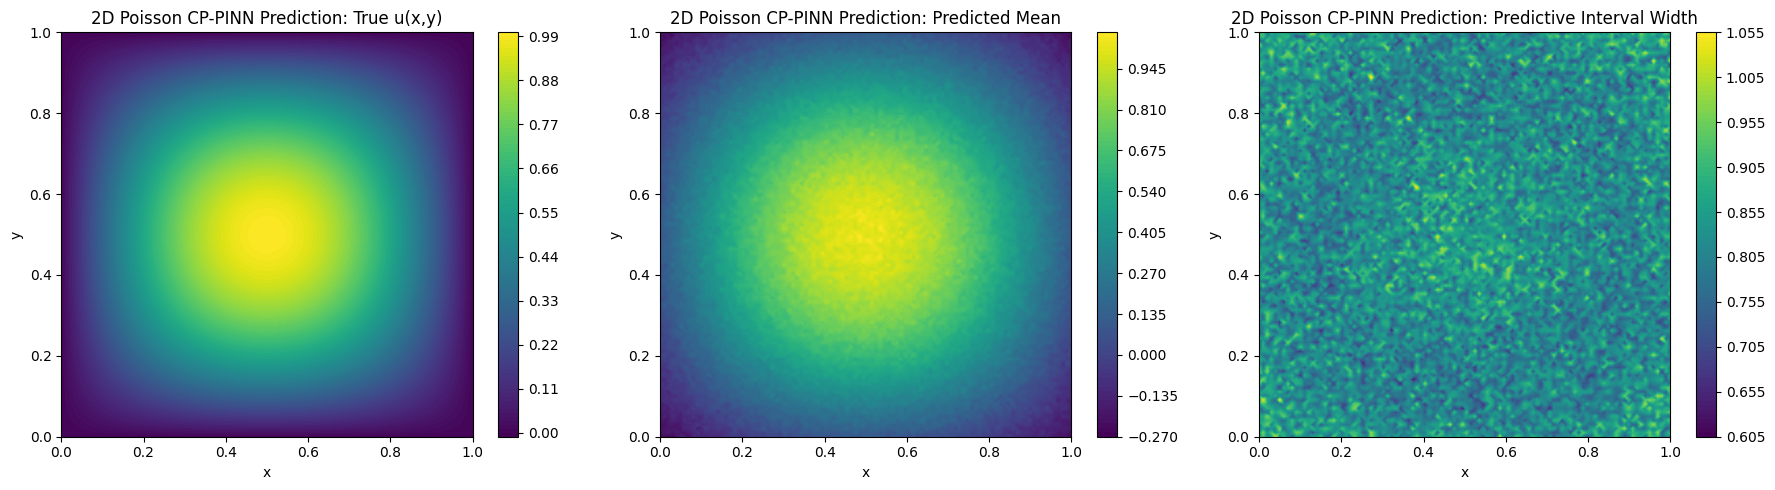

In [4]:
from utils_uq_dropout import DropoutPINN
from utils_result_viz import plot_predictions_2D
# --------------------------------------------
# 1. Define PDE and exact solution
# --------------------------------------------
data_noise = 0.001
pde = Poisson2D()
# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(500, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)



# --------------------------------------------
# 2. Build DO-PINN model (input: (x,y), output: u)
# --------------------------------------------
do_model = DropoutPINN(
    pde_class=pde,
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16],
    output_dim=1,
    p_drop=0.1,
    activation=torch.nn.Tanh()
)

# --------------------------------------------
# 3. Training configuration
# --------------------------------------------
loss_dict =do_model.fit_do_pinn(
    coloc_pt_num=1000,
    X_train=X_train,
    Y_train=Y_train,
    λ_pde=1.0,
    λ_bc=5.0,
    λ_ic=0.0,
    epochs=20000,
    lr=3e-3,
)

# --------------------------------------------
# 4. Prediction: generate grid for testing
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
XY_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Predict with conformal UQ
pred_set = do_model.predict(XY_test, alpha=0.05)  # 90% confidence

# --------------------------------------------
# 5. Visualize result
# --------------------------------------------
plot_predictions_2D(
    XY_test,
    pred_set,
    true_solution=pde.true_solution,
    title="2D Poisson CP-PINN Prediction"
)

In [5]:
from utils_result_metrics import do_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = do_test_uncertainties(do_model, alphas, X_test, Y_test, n_samples=100)

Using device: cpu


  0%|          | 0/8 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 8/8 [00:00<00:00, 22.15it/s]


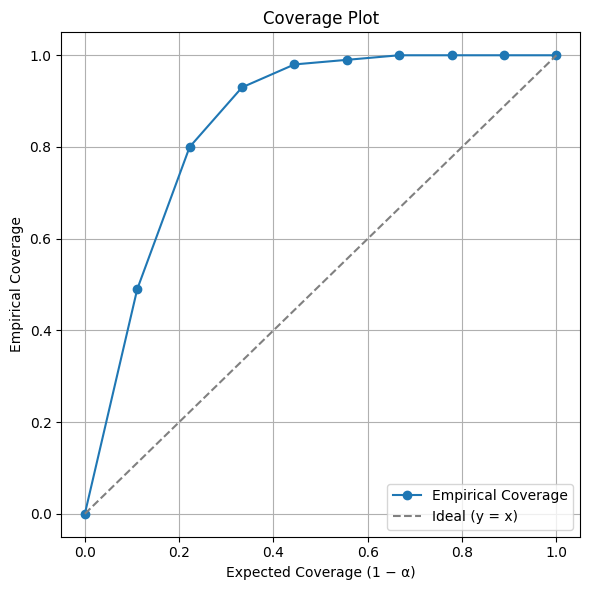

In [6]:
from utils_result_viz import plot_expected_vs_empirical
plot_expected_vs_empirical(rslt)

## Uncertainty Plot


In [7]:
# Suppose you predicted on a 101×101 grid:
n_grid = 101
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
Xg, Yg = torch.meshgrid(x, y, indexing='xy')
XY_test = torch.stack([Xg.flatten(), Yg.flatten()], dim=1)  # (N,2)

pred_set = do_model.predict(XY_test, n_samples=100)

plot_uncertainty_2D(
    pred_set,
    XY_test,
    n_x=n_grid,
    n_y=n_grid,
    title="Predictive-Interval Width (Dropout-PINN, 95 %)"
)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


NameError: name 'plot_uncertainty_2D' is not defined